<div align="center">

# Watt Tomorrow 
02.12.2025

By Group 5:

Oscar Albert Höglund

Erik Minh Le

Adrian Rod Hammerstad

Arjan Mahmuod

</div>

## Intro

### Introduction to the Problem
In this notebook, our goal is to predict next-day electricity prices. We will experiment with multiple models and evaluate their performance relative to one another. Specifically, we will compare a baseline naïve model against a Linear Regression model and an XGBoost model. In the end, we will save the best-performing model and deploy it so it can be accessed through a chatbot interface.

### Relevance
Since the onset of the war in Ukraine, energy bills have become a major concern across Europe. Many households have struggled with the rapid fluctuations in electricity prices, making budgeting and financial planning more difficult. We believe that a predictive model could help families by providing earlier insight into price changes, making it easier to plan consumption and manage costs.

### Explanation of the Data
The data used in this project comes from the Kaggle dataset *“Hourly Energy Demand Generation and Weather”* by **Kolasniwash**, available here:  
<https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?select=weather_features.csv>  
(Downloaded October 7th, 2025.)

The dataset is divided into two main components: weather data and energy data. The energy data contains the target variable we aim to predict: the electricity price. It also includes the **day-ahead price**, which represents the price agreed upon by the energy broker (ENTSO-E) one day in advance. The difference between the day-ahead price and the actual price arises from real-time fluctuations in supply and demand. For example, a factory may consume more electricity than expected, or wind production may drop due to lower-than-forecast wind speeds, causing deviations from the agreed-upon price.


## Loading dependancies and datasets

For convenience, we have downloaded the dataset as CSV files. In our project structure, these files are stored in a sibling folder to this notebook, named **`data`**, with the filenames **`energy_dataset.csv`** and **`weather_features.csv`**.

All library versions used in this notebook are listed in the accompanying **`requirements.txt`** file.


In [ ]:
# Imports 
import os
import warnings
import sys
import joblib, json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
# Load the main energy dataset used by this notebook
data_path = os.path.join('..', 'data', 'energy_dataset.csv')
print('Loading', data_path)
df = pd.read_csv(data_path)
print('Loaded df with shape', getattr(df, 'shape', None))
# Makes the columns have appriopriate data types
df = df.infer_objects(copy=False)

Loading ..\data\energy_dataset.csv
Loaded df with shape (35064, 29)


In [33]:
# Load weather features
weather_path = os.path.join('..', 'data', 'weather_features.csv')
print('Loading', weather_path)
weather = pd.read_csv(weather_path)
# Parse timestamp and convert to UTC
weather['time'] = pd.to_datetime(weather['dt_iso'], utc=True)
# Keep a numeric subset of weather features useful for modelling
weather_cols = ['time','temp','temp_min','temp_max','pressure','wind_speed','wind_deg','rain_1h','rain_3h','snow_3h']
weather_sub = weather[weather_cols].copy()
# If there are multiple city rows per timestamp, aggregate by mean
weather_sub = weather_sub.groupby('time').mean().reset_index()

Loading ..\data\weather_features.csv


## Data Preproccesing

### Handeling missing values

In [34]:
# Missing data in energy dataset
df.isna().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [ ]:
# Fixing missing data for energy
# Those columns missing more than the thershold of the data will get their NANs filled in as zero
# If not they will be subjected to interpolation

missing_threshold = 0.5
numeric_cols = df.select_dtypes(include=["number"]).columns

for col in numeric_cols:
    na_ratio = df[col].isna().mean()

    if na_ratio == 0:
        continue

    if na_ratio <= missing_threshold:
        # interpolate columns with few NaNs
        df[col] = df[col].interpolate(
            method="linear",
            limit_direction="both"
        )
    else:
        # fill with 0 if too many NaNs
        df[col] = df[col].fillna(0)

In [36]:
# Missing data in weather dataset
weather_sub.isna().sum()

time          0
temp          0
temp_min      0
temp_max      0
pressure      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
dtype: int64

We observe that the dataset contains very few missing values overall, with the exception of two columns. To address this, we apply **interpolation**, which is well-suited for time-series data and helps preserve the underlying temporal structure.

For the columns with a large proportion of missing data, we instead fill the gaps with zeros. While this may introduce slight deviations from real-world conditions, we expect the impact on model performance to be minimal.


### Feature engineering, extraction and merging the data

In [37]:
# Feature engineering on energy data (some aggregation)

# other
df["generation_other"] = df[
    [
        "generation biomass",
        "generation geothermal",
        "generation waste",
        "generation other",
        "generation other renewable",
        "generation marine",
        "generation fossil peat",
    ]
].sum(axis=1)

# coal
df["generation_coal"] = df[
    [
        "generation fossil brown coal/lignite",
        "generation fossil hard coal",
        "generation fossil coal-derived gas",
    ]
].sum(axis=1)

# oil
df["generation_oil"] = df[
    [
        "generation fossil oil",
        "generation fossil oil shale",
    ]
].sum(axis=1)

# hydro
df["generation_hydro"] = (
    df["generation hydro run-of-river and poundage"]
    + df["generation hydro water reservoir"]
    + df["generation hydro pumped storage aggregated"]
    - df["generation hydro pumped storage consumption"]
)

# natural gass
df["generation_natural_gas"] = df["generation fossil gas"]

# nuclear
df["generation_nuclear"] = df["generation nuclear"]

# solar
df["generation_solar"] = df["generation solar"]
df["forecast_solar"] = df["forecast solar day ahead"]

# wind
df["generation_wind"] = df[
    ["generation wind onshore", "generation wind offshore"]
].sum(axis=1)
df["forecast_wind"] = df[
    ["forecast wind onshore day ahead", "forecast wind offshore eday ahead"]
].sum(axis=1)

# select + rename
df = df[
    [
        "time",
        "generation_other",
        "generation_coal",
        "generation_oil",
        "generation_natural_gas",
        "generation_hydro",
        "generation_nuclear",
        "generation_solar",
        "forecast_solar",
        "generation_wind",
        "forecast_wind",
        "total load forecast",
        "total load actual",
        "price day ahead",
        "price actual",
    ]
].rename(
    columns={
        "total load forecast": "total_load_forecast",
        "total load actual": "total_load_actual",
        "price day ahead": "price_day_ahead",
        "price actual": "price_actual",
    }
)

In [38]:
# Merge the dataframes
if 'df' in globals():
    df['time'] = pd.to_datetime(df['time'], utc=True)
    before = len(df)
    df = df.merge(weather_sub, on='time', how='left')
    after = len(df)
    print(f'Merged weather features: df rows before={before}, after={after}')
else:
    print('`df` not found in kernel; weather file loaded into `weather` variable only.')

Merged weather features: df rows before=35064, after=35064


In [39]:
# Feature engineering on merged dataset

# Ensure 'time' column is datetime and create time-based features
df["time"] = pd.to_datetime(df["time"], errors="coerce", utc=True)
df["hour"] = df["time"].dt.hour
df["day"] = df["time"].dt.day
df["month"] = df["time"].dt.month
df["year"] = df["time"].dt.year
df["dayofweek"] = df["time"].dt.dayofweek    # Monday = 0, Sunday = 6
df["is_weekend"] = df["dayofweek"] >= 5      # True/False
df["dayofyear"] = df["time"].dt.dayofyear
df["weekofyear"] = df["time"].dt.isocalendar().week.astype(int)

# Forecast should give the forecast for tomorrow (the target)
df["forecast_solar"] = df["forecast_solar"].shift(-24)
df["forecast_wind"] = df["forecast_wind"].shift(-24)
df['total_load_forecast'] = df['total_load_forecast'].shift(-24)
df['price_day_ahead'] = df['price_day_ahead'].shift(-24)
for feature in weather_cols:
    df[feature] = df[feature].shift(-24)

# Add lagged features (24, 48, 72, ..., 144 hours)
lag_hours = [23, 24, 47, 48, 71, 72, 95, 96, 119, 120, 143, 144]
for hour_lag in lag_hours:
    df[f"price_actual_lag{hour_lag}"] = df["price_actual"].shift(hour_lag)


# Add rolling statistics features
df["price_actual_rolling_mean_24"] = df["price_actual"].rolling(window=24).mean()
df["price_actual_rolling_std_24"] = df["price_actual"].rolling(window=24).std()
df["total_load_actual_rolling_mean_24"] = df["total_load_actual"].rolling(window=24).mean()

# Target = tomorrow’s actual price
target = "target_price_tomorrow"
df[target] = df["price_actual"].shift(-24)

# Drop rows with NaN values created by lags and rolling statistics, and the target
df = df.dropna(subset=[target])
df = df.dropna()

For our data engineering process, we began by merging related energy-generation features into broader categories. For example, we combined the generation from *hard coal*, *brown coal*, and *coal-derived gas* into a single aggregated coal-based generation feature.

Next, we merged the weather data with the energy data to create a unified dataset.

From there, we structured each data point according to the following plan:  
our objective is to predict the electricity price at the **same hour on the next day**, which serves as our target variable. Each data point should contain information available at the current hour, this includes both real-time measurements and historical data from previous days and weeks. It also includes forecasted information that would realistically be known ahead of time, such as next-day weather forecasts and the day-ahead price.

To incorporate historical behavior, we created **lag features**, capturing the price at the same hour and at the following hour for each of the previous six days. In addition, we generated **rolling statistical features** to summarize recent trends, such as metrics based on the past 24 hours.

Finally, we engineered temporal features from the timestamps, such as hour of the day, day of the week, week of the year, and year, to help the models learn recurring patterns, trends, and seasonality present in the data.


In [15]:
# Displaying description of all of the features
desc = df.describe().T
#desc.to_csv("describe_summary.csv", index=True) # saving to csv
display(desc)

,count,mean,std,min,25%,50%,75%,max
generation_other,34896.0,799.078476,90.794629,0.000000,750.000000,804.000000,854.000000,1063.000000
generation_coal,34896.0,4712.406494,2243.865128,0.000000,2692.750000,4994.500000,6507.000000,9320.000000
generation_oil,34896.0,298.546051,52.298034,0.000000,263.000000,300.000000,330.000000,449.000000
generation_natural_gas,34896.0,5629.199908,2203.462511,0.000000,4131.000000,4975.500000,6436.000000,20034.000000
generation_hydro,34896.0,3101.381090,2402.775950,-3530.000000,1415.000000,2804.000000,4575.000000,11613.000000
generation_nuclear,34896.0,6263.928846,838.007120,0.000000,5760.750000,6561.500000,7023.000000,7117.000000
generation_solar,34896.0,1432.251304,1679.890713,0.000000,71.000000,616.000000,2574.000000,5792.000000
forecast_solar,34896.0,1437.809520,1677.227420,0.000000,69.000000,575.000000,2631.000000,5836.000000
generation_wind,34896.0,5460.008282,3212.601616,0.000000,2931.000000,4846.500000,7389.000000,17436.000000
forecast_wind,34896.0,5464.374656,3175.322749,237.000000,2975.000000,4847.000000,7337.250000,17430.000000


We decided not to standardize or normalize the data. Based on our understanding, doing so would not provide meaningful benefits for our chosen models beyond slightly reducing training time and making feature importance in Linear Regression easier to interpret. By keeping the data in its original scale, we preserve interpretability and maintain a more intuitive relationship between the input features and their real-world meaning.


## Visualization of data

### Price evolution

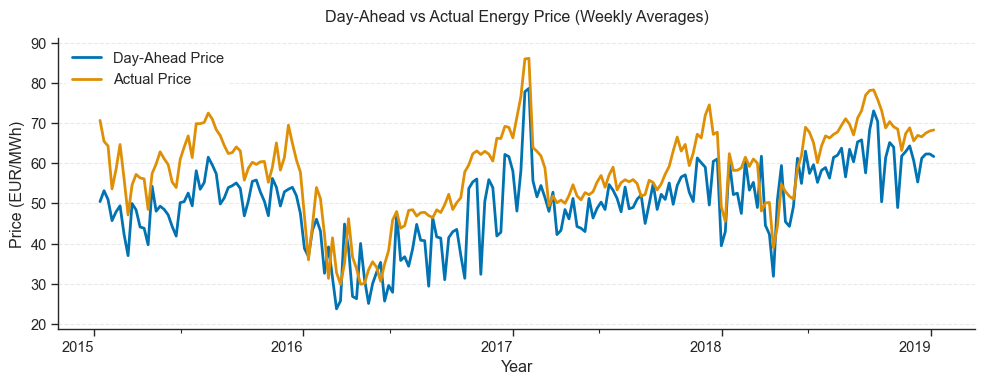

In [ ]:
# Initial plot
# --- Warnings --- (this is here in order to supress some warnings)
warnings.filterwarnings(
    "ignore",
    message="use_inf_as_na option is deprecated"
)
warnings.filterwarnings(
    "ignore",
    message="When grouping with a length-1 list-like, you will need to pass a length-1 tuple"
)

# ================================================================
# 1. Data prep (weekly resample + tidy format)
# ================================================================
# Ensure time is datetime
df["time"] = pd.to_datetime(df["time"], errors="coerce")

# Weekly resample over full period
df_weekly = (
    df.set_index("time")[["price_day_ahead", "target_price_tomorrow"]]
      .resample("W")
      .mean()
      .rename(columns={
          "price_day_ahead": "Day-Ahead Price",
          "target_price_tomorrow" : "Actual Price"
      })
      .reset_index()
)

# Long format for seaborn
df_long = df_weekly.melt(
    id_vars="time",
    var_name="Price Type",
    value_name="Price"
)

# Drop any missing values that might break plotting
df_long = df_long.dropna(subset=["Price"])

# ================================================================
# 2. Plot style
# ================================================================
sns.set_theme(
    style="ticks",
    context="paper",
    font_scale=1.2,
)

# colorblind-friendly and consistent ordering
palette = sns.color_palette("colorblind", 2)
hue_order = ["Day-Ahead Price", "Actual Price"]

# ================================================================
# 3. Figure + lineplot
# ================================================================
fig, ax = plt.subplots(figsize=(10, 4))  # slightly more compact for reports

sns.lineplot(
    data=df_long,
    x="time",
    y="Price",
    hue="Price Type",
    hue_order=hue_order,
    palette=palette,
    linewidth=2,
    ax=ax,
)

# ================================================================
# 4. Axes formatting
# ================================================================
ax.set_title(
    "Day-Ahead vs Actual Energy Price (Weekly Averages)",
    pad=12
)
ax.set_xlabel("Year")
ax.set_ylabel("Price (EUR/MWh)")

# X-axis: yearly ticks + mid-year minor ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(6,)))

fig.autofmt_xdate(rotation=0)

# Y-axis: nice padding and zero floor if appropriate
ymin, ymax = df_long["Price"].min(), df_long["Price"].max()
ax.set_ylim(bottom=max(0, ymin - 5), top=ymax + 5)

# Grid: light horizontal only
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
ax.xaxis.grid(False)

# Remove top/right spines
sns.despine(ax=ax)

# Legend: clean, outside top-left if you want to avoid overlapping
leg = ax.legend(
    title="",
    loc="upper left",
    frameon=True,
    framealpha=0.9,
)
leg.get_frame().set_linewidth(0)

plt.tight_layout()

plt.show()

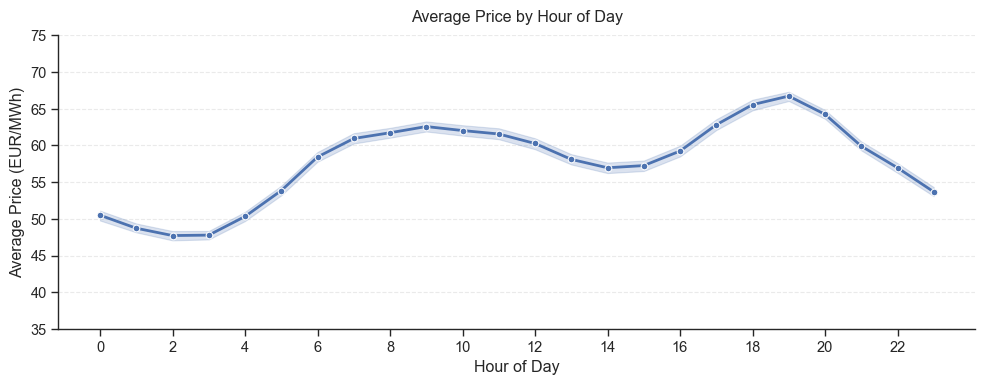

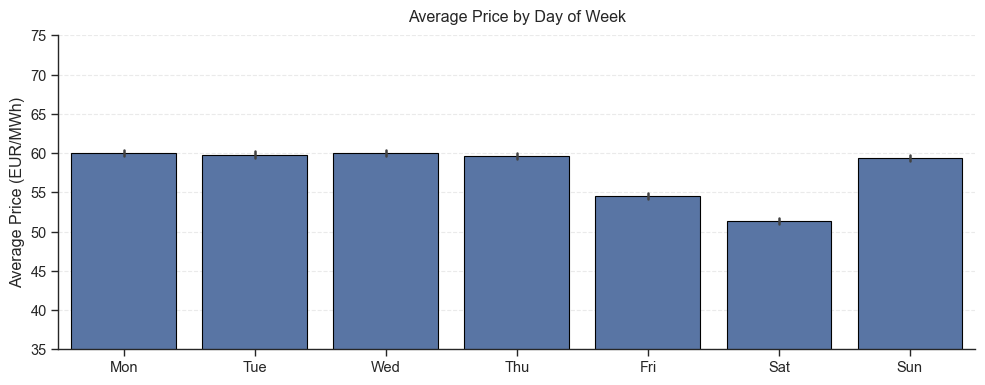

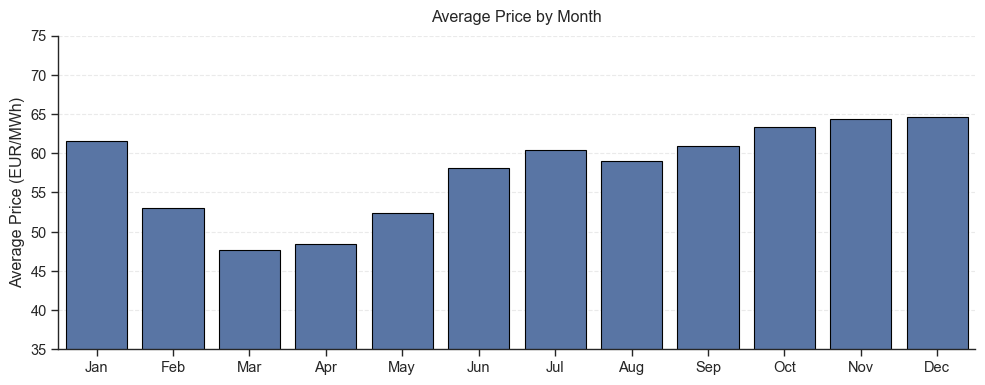

In [ ]:
# Periodic plots

# -----------------------------
# Global settings
# -----------------------------
warnings.filterwarnings(
    "ignore",
    message="DataFrameGroupBy.apply operated on the grouping columns",
)

sns.set_theme(style="ticks", context="paper", font_scale=1.2)

target = "target_price_tomorrow"

# Cropping of the axis
ymin = 35
ymax = 75

# Day-of-week order and labels (0=Mon,...,6=Sun)
dow_order  = [0, 1, 2, 3, 4, 5, 6]
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Month order and labels (1=Jan,...,12=Dec)
month_order  = list(range(1, 13))
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# -----------------------------
# 1) Average price by HOUR
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    data=df,
    x="hour",
    y=target,
    estimator="mean",
    errorbar=("ci", 95),
    linewidth=2,
    marker="o",
    ax=ax,
)

ax.set_ylim(ymin, ymax)
ax.set_title("Average Price by Hour of Day", pad=10)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Price (EUR/MWh)")
ax.set_xticks(range(0, 24, 2))
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

# -----------------------------
# 2) Average price by DAY OF WEEK
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    data=df,
    x="dayofweek",
    y=target,
    order=dow_order,
    color="C0",
    errorbar=("ci", 95),
    edgecolor="black",
    ax=ax,
)

ax.set_ylim(ymin, ymax)
ax.set_title("Average Price by Day of Week", pad=10)
ax.set_xlabel("")
ax.set_ylabel("Average Price (EUR/MWh)")
ax.set_xticks(dow_order)
ax.set_xticklabels(dow_labels)
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

# -----------------------------
# 3) Average price by MONTH
# -----------------------------
# Pre-aggregate so it's explicit
df_month = (
    df.groupby("month", as_index=False)[target]
      .mean()
      .rename(columns={target: "avg_price"})
)

fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    data=df_month,
    x="month",
    y="avg_price",
    order=month_order,       # 1 to 12
    color="C0",
    edgecolor="black",
    ax=ax,
)

ax.set_xticks(range(len(month_order)))                # 0..11
ax.set_xticklabels(month_labels)                     # Jan..Dec

ax.set_ylim(ymin, ymax)
ax.set_title("Average Price by Month", pad=10)
ax.set_xlabel("")
ax.set_ylabel("Average Price (EUR/MWh)")

ax.yaxis.grid(True, linestyle="--", alpha=0.4)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

Some observations:

- The **day-ahead price** is generally lower than the actual price, which is a relationship our model may learn and rely on.
- There is visible **seasonality** in the data on a broader scale, although the price often centers around roughly 60 EUR/MWh.
- Prices tend to be **lower during nighttime** and **higher in the hours following the end of the workday**.
- **Weekend prices** are usually lower, particularly on Fridays and Saturdays.
- During **spring and the surrounding months**, electricity prices appear to be lower on average.

### Coralation and autocorallation

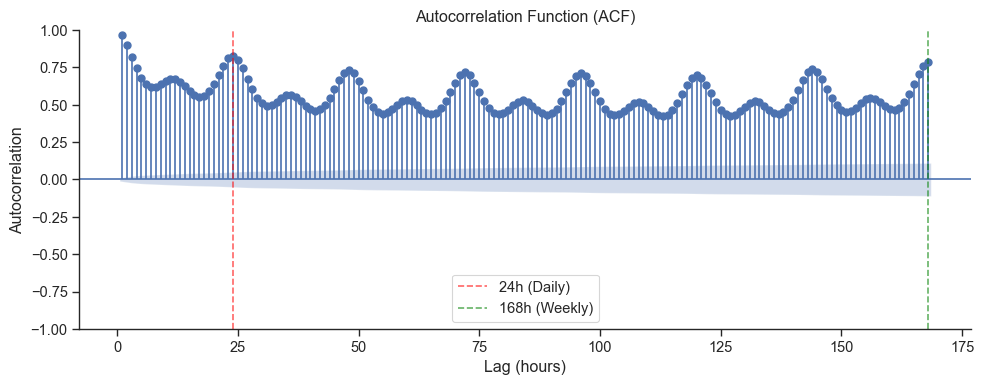

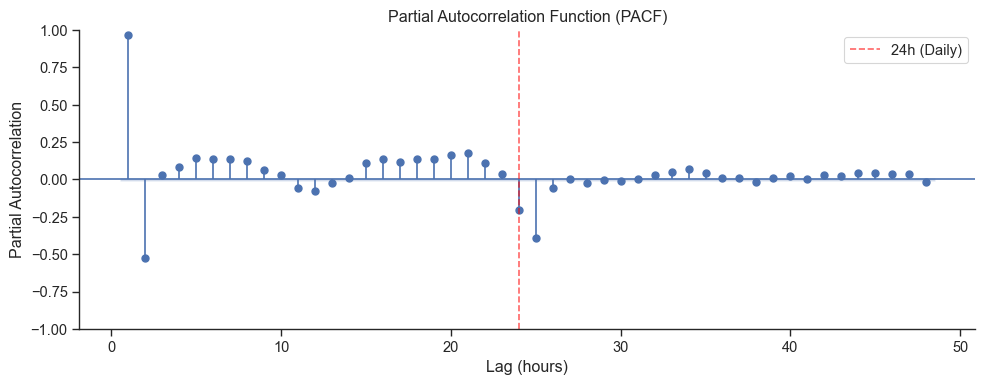

In [18]:
# Autocorralation and Partial autocorallation

sns.set_theme(style="ticks", context="paper", font_scale=1.2)

series = df[target].dropna()

# --------------------------
# ACF (up to 1 week)
# --------------------------
fig, ax = plt.subplots(figsize=(10, 4))

plot_acf(series, lags=168, ax=ax, zero=False)

# highlight daily + weekly lags
ax.axvline(24, color="red", linestyle="--", alpha=0.6, label="24h (Daily)")
ax.axvline(168, color="green", linestyle="--", alpha=0.6, label="168h (Weekly)")

ax.set_title("Autocorrelation Function (ACF)")
ax.set_xlabel("Lag (hours)")
ax.set_ylabel("Autocorrelation")
ax.legend()

sns.despine()
plt.tight_layout()
plt.show()

# --------------------------
# PACF (up to 48 hours)
# --------------------------
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(series, lags=48, ax=ax, zero=False, method="ywm")

# highlight daily lag
ax.axvline(24, color="red", linestyle="--", alpha=0.6, label="24h (Daily)")

ax.set_title("Partial Autocorrelation Function (PACF)")
ax.set_xlabel("Lag (hours)")
ax.set_ylabel("Partial Autocorrelation")
ax.legend()

sns.despine()
plt.tight_layout()
plt.show()


/var/folders/tm/flcqgtbd1vl1bzvkh0xxnnlm0000gn/T/ipykernel_89533/951196226.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


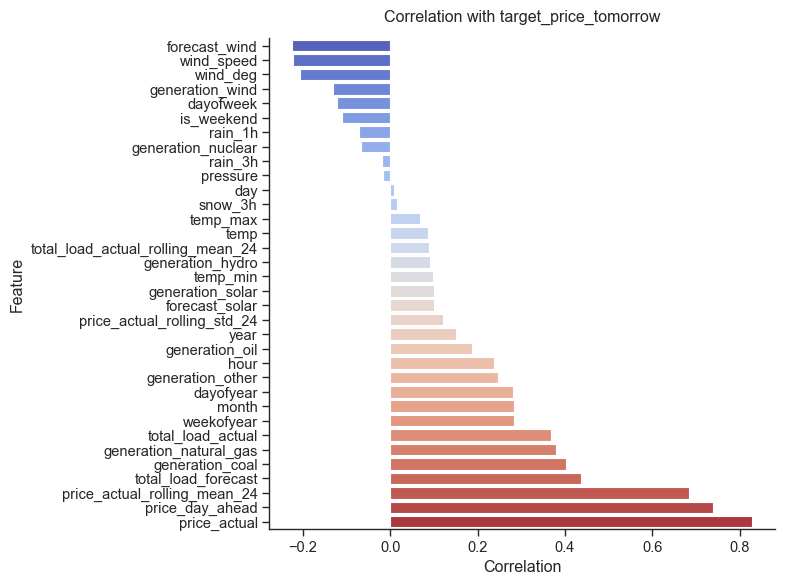

In [19]:
# Corralation
corr = (
    df
    .drop(columns=[col for col in df.columns if col.startswith("price_actual_lag")])
    .corr(numeric_only=True)
)
corr_target = corr[target].drop(target).sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(
    x=corr_target.values,
    y=corr_target.index,
    palette="coolwarm"
)
plt.title(f"Correlation with {target}", pad=12)
plt.xlabel("Correlation")
plt.ylabel("Feature")
sns.despine()
plt.tight_layout()
plt.show()


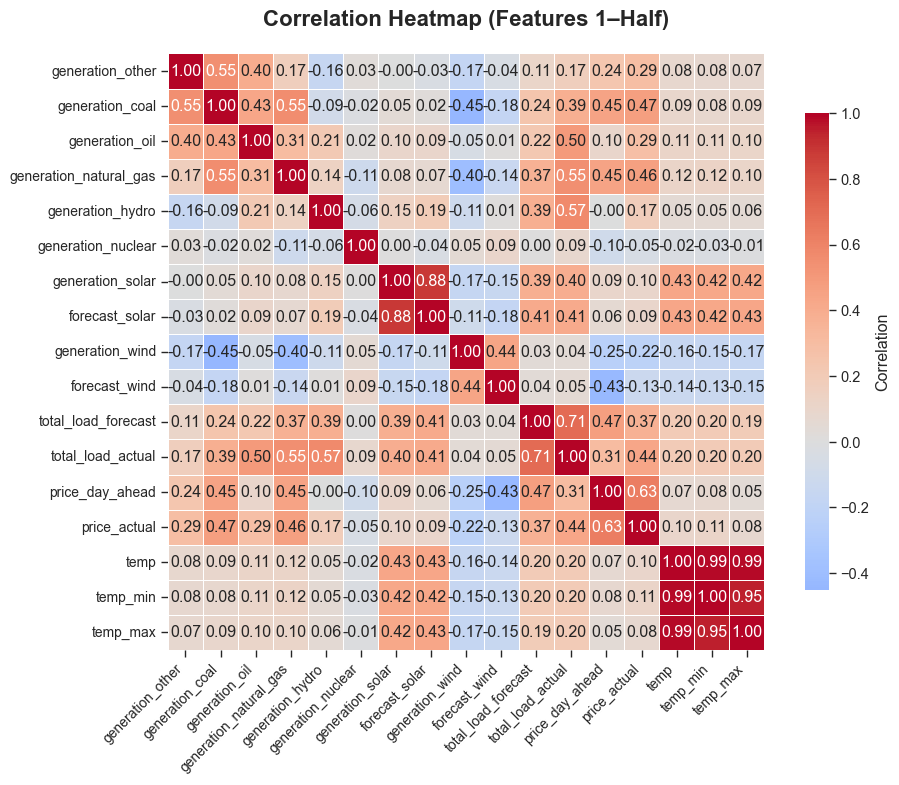

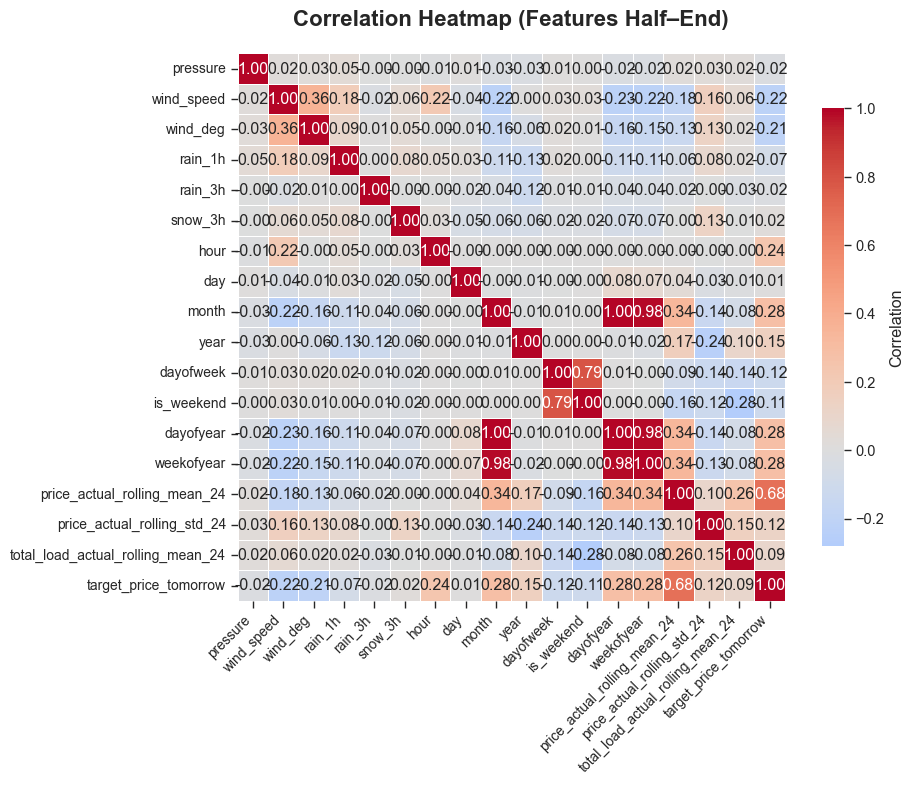

In [ ]:
# Corralation heatmap
# Splits into two heatmaps beacuse there are too many features for one big 
# to be readable.
n_features = corr.shape[0]
half = n_features // 2

corr_1 = corr.iloc[:half, :half]
corr_2 = corr.iloc[half:, half:]

# First heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_1,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)
plt.title("Correlation Heatmap (Features 1–Half)", fontsize=16, weight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Second heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_2,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)
plt.title("Correlation Heatmap (Features Half–End)", fontsize=16, weight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Some observations:

- We observe a high degree of **autocorrelation on a day-to-day basis**, indicating that features capturing these recurring patterns and spikes are likely to be beneficial.
- The **hours immediately before and after** a given timestamp also show strong relationships with the target and therefore serve as valuable predictive features.
- The **generation of coal and natural gas** is surprisingly well-correlated with price levels, hinting at the continued influence of fossil-fuel-based production on market prices.
- The **current day’s price** appears to be a stronger indicator of the next day’s price than the *day-ahead* price itself.


## Modelling

### Performing Time Series Cross-Validation
Because we are working with time-series data, it is essential to use a validation method that **preserves the temporal order** of the observations. For this reason, we apply **time series cross-validation**, which partitions the data into sequential folds without randomly shuffling the timestamps.

We will evaluate three models:  
1. a **naïve baseline model**,  
2. a **Linear Regression model**, and  
3. an **XGBoost model**.  

In addition to comparing these models, we will also investigate whether training a model **exclusively on data from a single hour of the day** yields better performance than training on **all 24 hours** combined. This allows us to test whether hour-specific patterns are strong enough to justify building hour-specific models.


In [21]:
# Defining a function for using time series cross validation
def evaluate_time_series_cv(X, y, model, splits=5):
    tscv = TimeSeriesSplit(n_splits=splits)
    fold_mae_scores = []
    fold_rmse_scores = []
    fold_r2_scores = []

    last_y_test = None
    last_y_pred = None
    last_model = None
    
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test= X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fresh model per fold
        model_ = clone(model)

        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        fold_mae_scores.append(mae)
        fold_rmse_scores.append(rmse)
        fold_r2_scores.append(r2)
        if i == splits-1:
            last_y_test = y_test
            last_y_pred = y_pred
            last_model = model_

    
    return {
        "mae_mean": np.mean(fold_mae_scores),
        "mae_std": np.std(fold_mae_scores),
        "rmse_mean": np.mean(fold_rmse_scores),
        "rmse_std": np.std(fold_rmse_scores),
        "r2_mean": np.mean(fold_r2_scores),
        "r2_std": np.std(fold_r2_scores),
        "y_test": last_y_test,
        "y_pred": last_y_pred,
        "model": last_model
    }

In [23]:
# Defining functions for testing if a model trained on only one hour time slot would be any better
def hourly_model_cv(X,y, model, splits=5, target = "target_price_tomorrow"):
    hourly_mae_scores = np.empty(24)
    hourly_rmse_scores = np.empty(24)
    hourly_r2_scores = np.empty(24)
    X_grouped_by_hour = X.groupby('hour')
    # Iterate through each hour
    for hour, X_hour in X_grouped_by_hour:

        X_hour = X_hour.drop('hour', axis=1)
        y_hour = y.loc[X_hour.index]

        X_hour = X_hour.reset_index(drop=True)
        y_hour = y_hour.reset_index(drop=True)

        results = evaluate_time_series_cv(X_hour,y_hour, model, splits)

        # Store the average scores for the hour
        hourly_mae_scores[hour] = results["mae_mean"]
        hourly_rmse_scores[hour] = results["rmse_mean"]
        hourly_r2_scores[hour] = results["r2_mean"]

    return {
        "mae_mean": np.mean(hourly_mae_scores),
        "mae_std": np.std(hourly_mae_scores),
        "rmse_mean": np.mean(hourly_rmse_scores),
        "rmse_std": np.std(hourly_rmse_scores),
        "r2_mean": np.mean(hourly_r2_scores),
        "r2_std": np.std(hourly_r2_scores)
    }

In [ ]:
# Splitting the data into a train and test set
df = df.sort_values("time") # Make sure that the data is sortet by time
split_idx = int(len(df) * 0.9) # 90% train, 10% test
train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

features = [col for col in df.columns if col not in ["time", target]]
X_train = train_df[features]
y_train = train_df[target]

X_test  = test_df[features]
y_test  = test_df[target]

In [53]:
# Performing time series cross validation on different models (this should take 2-5 min)

class NaiveLastValueRegressor(BaseEstimator, RegressorMixin):
    """
    This class takes the "price actual" inside of X and returns this as the prediction.
    Price actual is the price today and what we are prediciting is target_price_tomorrow.
    The reason this class was made is simply so that we can pass a naive model into the cross validation function
    """
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X["price_actual"].values

model_naive = NaiveLastValueRegressor()
model_lin = LinearRegression()
model_xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

result_naive_day_ahead = evaluate_time_series_cv(X_train,y_train,model_naive,splits=20)
result_lin_day_ahead = evaluate_time_series_cv(X_train,y_train,model_lin,splits=20)
result_xgb_day_ahead = evaluate_time_series_cv(X_train,y_train,model_xgb,splits=20)

In [ ]:
# Performing time series cross validation on hour by hour models (this should take 10-15 min)
result_lin_hour_by_hour = hourly_model_cv(X_train,y_train,model_lin,splits=5)
result_xgb_hour_by_hour = hourly_model_cv(X_train,y_train,model_xgb,splits=5)

### Comparing the models

In [34]:
# Showing a table of the results from the different modells
results_dict = {
    "LinearRegression (LR)": result_lin_day_ahead,
    "LR hour by hour": result_lin_hour_by_hour,
    "XGBRegressor (XGBR)": result_xgb_day_ahead,
    "XGBR hour by hour": result_xgb_hour_by_hour,
    "Naive": result_naive_day_ahead
}

rows = []
for model_name, res in results_dict.items():
    rows.append({
        "model": model_name,
        "MAE_mean":  res["mae_mean"],
        "MAE_std":   res["mae_std"],
        "RMSE_mean": res["rmse_mean"],
        "RMSE_std":  res["rmse_std"],
        "R2_mean":   res["r2_mean"],
        "R2_std":    res["r2_std"],
    })

metrics_df = pd.DataFrame(rows).set_index("model")

# sort by best (lowest) RMSE
metrics_df = metrics_df.sort_values("RMSE_mean")

baseline_name = "Naive"
baseline_rmse = metrics_df.loc[baseline_name, "RMSE_mean"]
baseline_mae = metrics_df.loc[baseline_name, "MAE_mean"]

metrics_df["RMSE_improvement_%"] = (
    100 * (1 - metrics_df["RMSE_mean"] / baseline_rmse)
)

metrics_df["MAE_improvement_%"] = (
    100 * (1 - metrics_df["MAE_mean"] / baseline_mae)
)

pretty_table = pd.DataFrame({
    "MAE":  metrics_df.apply(lambda r: f"{r.MAE_mean:.2f} ± {r.MAE_std:.2f}", axis=1),
    "RMSE": metrics_df.apply(lambda r: f"{r.RMSE_mean:.2f} ± {r.RMSE_std:.2f}", axis=1),
    "R²":   metrics_df.apply(lambda r: f"{r.R2_mean:.2f} ± {r.R2_std:.2f}", axis=1),
    "ΔRMSE vs Baseline (%)":
        metrics_df["RMSE_improvement_%"].apply(lambda x: f"{x:.1f}%"),
    "ΔMAE vs Baseline (%)":
        metrics_df["MAE_improvement_%"].apply(lambda x: f"{x:.1f}%"),
})


pretty_table

,MAE,RMSE,R²,ΔRMSE vs Baseline (%),ΔMAE vs Baseline (%)
model,,,,,
XGBRegressor (XGBR),3.50 ± 1.18,5.11 ± 1.67,0.73 ± 0.09,35.7%,39.1%
LinearRegression (LR),4.75 ± 1.24,6.27 ± 1.56,0.57 ± 0.14,21.0%,17.4%
LR hour by hour,4.96 ± 0.25,6.57 ± 0.24,0.64 ± 0.05,17.2%,13.7%
XGBR hour by hour,4.65 ± 0.19,6.68 ± 0.27,0.64 ± 0.06,15.8%,19.0%
Naive,5.75 ± 1.58,7.94 ± 2.08,0.33 ± 0.19,0.0%,0.0%


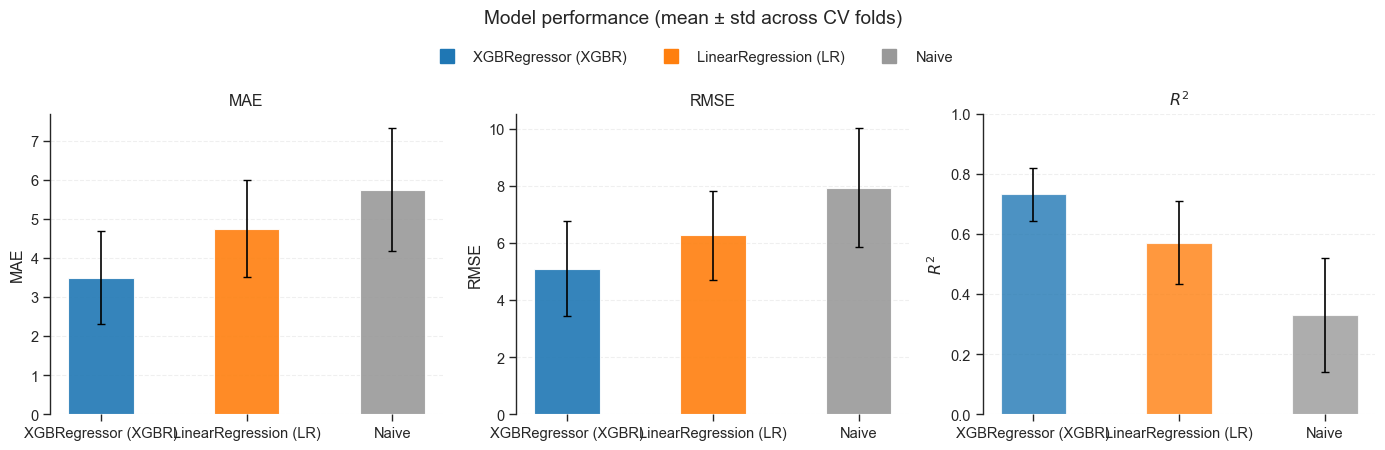

In [ ]:
# Visualising the performance of all the modells

# Ensure metrics are sorted by best (lowest) RMSE
metrics_ordered = metrics_df.drop(["XGBR hour by hour", "LR hour by hour"]).sort_values("RMSE_mean")
models = metrics_ordered.index.to_list()
x = np.arange(len(models))
width = 0.45

# --- Colors: grey for baseline (Naive), distinct colors for others ---
baseline_name = "Naive"
non_baseline = [m for m in models if m != baseline_name]

palette = sns.color_palette("tab10", n_colors=len(non_baseline))
color_map = {}
for m in models:
    if m == baseline_name:
        color_map[m] = (0.6, 0.6, 0.6)  # neutral grey baseline
    else:
        color_map[m] = palette[non_baseline.index(m)]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# -------------------- MAE --------------------
ax = axes[0]
mae_vals = metrics_ordered["MAE_mean"].values
mae_errs = metrics_ordered["MAE_std"].values

ax.bar(
    x,
    mae_vals,
    yerr=mae_errs,
    width=width,
    capsize=3,
    color=[color_map[m] for m in models],
    ecolor="black",
    alpha=0.9,
)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.set_ylabel("MAE")
ax.set_title("MAE")
ax.yaxis.grid(True, linestyle="--", alpha=0.3)
sns.despine(ax=ax, bottom=True)

# -------------------- RMSE --------------------
ax = axes[1]
rmse_vals = metrics_ordered["RMSE_mean"].values
rmse_errs = metrics_ordered["RMSE_std"].values

ax.bar(
    x,
    rmse_vals,
    yerr=rmse_errs,
    width=width,
    capsize=3,
    color=[color_map[m] for m in models],
    ecolor="black",
    alpha=0.9,
)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.set_ylabel("RMSE")
ax.set_title("RMSE")
ax.yaxis.grid(True, linestyle="--", alpha=0.3)
sns.despine(ax=ax, bottom=True)

# -------------------- R2 --------------------
ax = axes[2]
r2_vals = metrics_ordered["R2_mean"].values
r2_errs = metrics_ordered["R2_std"].values

ax.bar(
    x,
    r2_vals,
    yerr=r2_errs,
    width=width,
    capsize=3,
    color=[color_map[m] for m in models],
    ecolor="black",
    alpha=0.8,
)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.set_ylabel(r"$R^2$")
ax.set_title(r"$R^2$")
ax.set_ylim(0, 1)
ax.yaxis.grid(True, linestyle="--", alpha=0.3)
sns.despine(ax=ax, bottom=True)

# -------------------- Shared legend & figure title --------------------
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        linestyle="",
        color=color_map[m],
        label=m,
        markersize=10,
    )
    for m in models
]

fig.legend(
    handles=handles,
    labels=models,
    loc="upper center",
    ncol=len(models),
    bbox_to_anchor=(0.5, 1.05),
    frameon=False,
)

fig.suptitle("Model performance (mean ± std across CV folds)", y=1.12)

plt.tight_layout(rect=[0, 0, 1, 1.05])
plt.show()


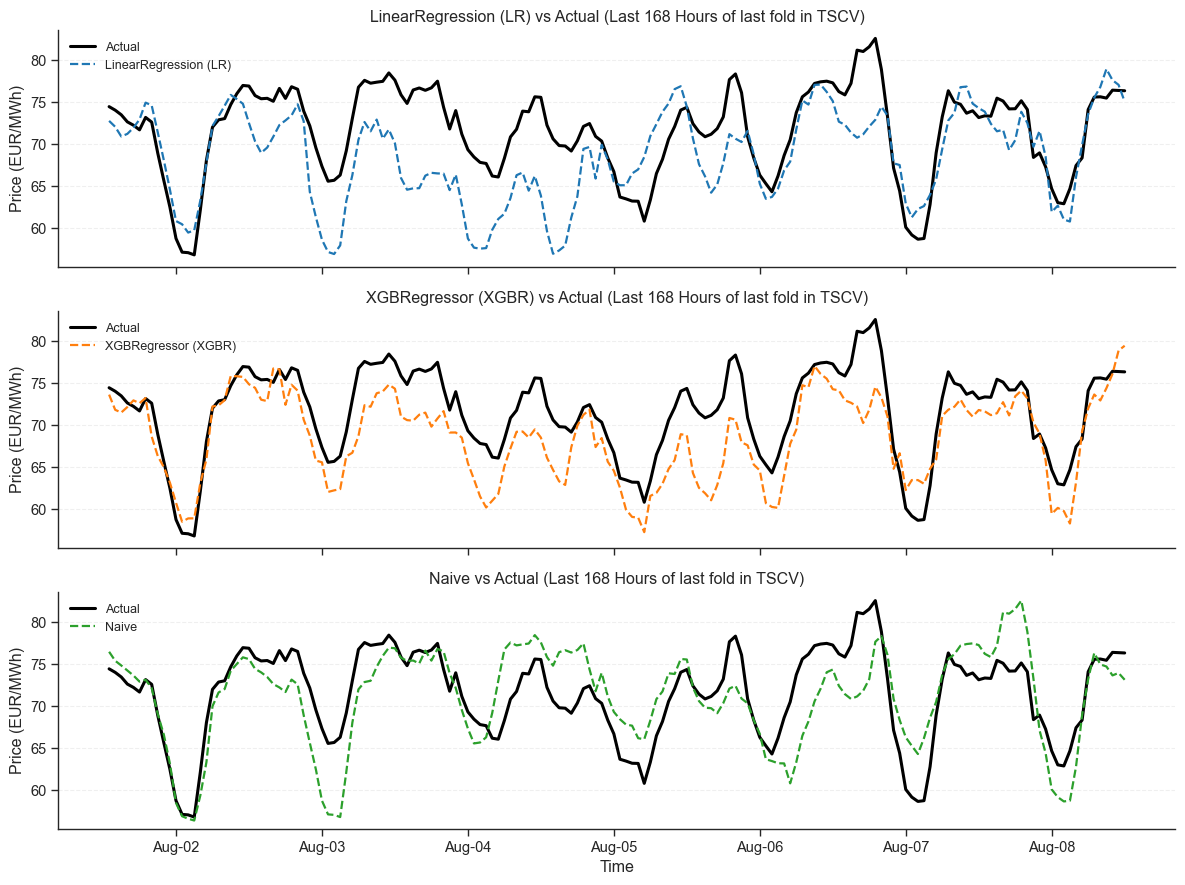

In [36]:
# Plotting prediction vs actual for the last 168 hours of the last fold

reduced_results_dict = {k: v for k, v in results_dict.items() if k not in ["LR hour by hour","XGBR hour by hour"]}

last_y_test = result_lin_day_ahead["y_test"]
last_index = last_y_test.index

# time axis
if "time" in df.columns:
    time_index = df.loc[last_index, "time"]
else:
    time_index = last_index

# zoom to last week (168 hours)
zoom_n = 168
time_zoom = time_index.iloc[-zoom_n:]
actual_zoom = last_y_test.iloc[-zoom_n:]

models = list(reduced_results_dict.keys())
n_models = len(models)

# y-limits shared across all subplots
y_min = float(min(actual_zoom.min(), min(pd.Series(res["y_pred"][-zoom_n:]).min()
                                        for res in reduced_results_dict.values())))
y_max = float(max(actual_zoom.max(), max(pd.Series(res["y_pred"][-zoom_n:]).max()
                                        for res in reduced_results_dict.values())))
y_pad = 1.0
y_min, y_max = y_min - y_pad, y_max + y_pad

# color palette for models
palette = sns.color_palette("tab10", n_colors=n_models)

fig, axes = plt.subplots(
    n_models, 1,
    figsize=(12, 3 * n_models),
    sharex=True,
    sharey=True
)

# if only one model, axes is not an array
if n_models == 1:
    axes = [axes]

for i, (model_name, res) in enumerate(reduced_results_dict.items()):
    ax = axes[i]
    color = palette[i]

    # model predictions for the zoom window
    y_pred_full = pd.Series(res["y_pred"], index=last_index)
    y_pred_zoom = y_pred_full.iloc[-zoom_n:]

    # Actual: thick black line
    ax.plot(time_zoom, actual_zoom, color="black", linewidth=2.2, label="Actual")

    # Model: colored dashed line
    ax.plot(time_zoom, y_pred_zoom, color=color, linewidth=1.6,
            linestyle="--", label=model_name)

    ax.set_ylim(y_min, y_max)
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax)

    # Titles & labels
    ax.set_title(f"{model_name} vs Actual (Last 168 Hours of last fold in TSCV)")
    ax.set_ylabel("Price (EUR/MWh)")

    # Legend inside each subplot (small)
    ax.legend(loc="upper left", fontsize=9, frameon=False)

# x-axis only on bottom
axes[-1].set_xlabel("Time")
axes[-1].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
plt.setp(axes[-1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


First, we observe that the **hour-by-hour modeling approach did not perform well**. This is likely due to the reduced number of training samples available for each individual hour, limiting the model’s ability to learn meaningful patterns. In addition, these hour-specific models miss the broader context that the full model, trained on all hours, can leverage. Because their performance was significantly worse, we chose not to include visualizations for them.

We also see that the **XGBRegressor is clearly the best-performing model**. Linear Regression performs worse, but still outperforms the baseline model.  
XGBoost likely performs better because it is capable of:

- capturing **nonlinear relationships** in the data,  
- handling **feature interactions** automatically,  
- adapting to **complex seasonal and temporal patterns**, and  
- being more robust to the varying scales and distributions of the input features.

These strengths give XGBoost a natural advantage over a simple linear model for this type of problem.

### Residual analysis

In [ ]:
# Function for residual analasys
def residual_analysis_ts(y_test, y_pred, model_name="Model", max_lag=168):
    """
    Time-series oriented residual analysis:
      - residuals over time (with rolling mean)
      - ACF of residuals
      - residuals vs fitted
      - residuals by hour-of-day / day-of-week (if available)
      - summary statistics
    """
    # Ensure Series with aligned index
    y_test = pd.Series(y_test)
    y_pred = pd.Series(y_pred, index=y_test.index)
    residuals = y_test - y_pred

    # --- Time index ---
    if "time" in df.columns:
        time_index = df.loc[y_test.index, "time"]
    else:
        time_index = y_test.index

    resid_ts = pd.Series(residuals.values, index=time_index, name="residual")

    # ======================================================
    # Figure 1: time behavior, ACF, and residual vs fitted
    # ======================================================
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # 1) Residuals over time + rolling mean
    ax = axes[0, 0]
    ax.plot(resid_ts.index, resid_ts.values, alpha=0.5, label="Residual")
    ax.axhline(0, color="red", linestyle="--", linewidth=1.5, label="Zero")

    # Rolling mean (e.g. 24h window if hourly)
    if len(resid_ts) > 24:
        roll_mean = resid_ts.rolling(window=24, center=True).mean()
        ax.plot(roll_mean.index, roll_mean.values, color="black", linewidth=1.5,
                label="24h rolling mean")

    ax.set_title(f"{model_name}: Residuals Over Time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Residual")
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax)
    ax.legend(loc="upper right", frameon=False)

    # 2) ACF of residuals
    ax = axes[0, 1]
    plot_acf(residuals, lags=max_lag, ax=ax, zero=False)
    ax.set_title(f"{model_name}: ACF of Residuals\n(white noise ≈ no significant spikes)")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax)

    # 3) Residuals vs fitted (check heteroskedasticity / structure)
    ax = axes[1, 0]
    ax.scatter(y_pred.values, residuals.values, alpha=0.4, s=15)
    ax.axhline(0, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(f"{model_name}: Residuals vs Predicted")
    ax.set_xlabel("Predicted value")
    ax.set_ylabel("Residual")
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax)

    # 4) Predicted vs actual
    ax = axes[1, 1]
    ax.scatter(y_test.values, y_pred.values, alpha=0.4, s=15)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val],
            "r--", linewidth=1.5, label="Perfect prediction")
    ax.set_title(f"{model_name}: Predicted vs Actual")
    ax.set_xlabel("Actual value")
    ax.set_ylabel("Predicted value")
    ax.legend(frameon=False)
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()

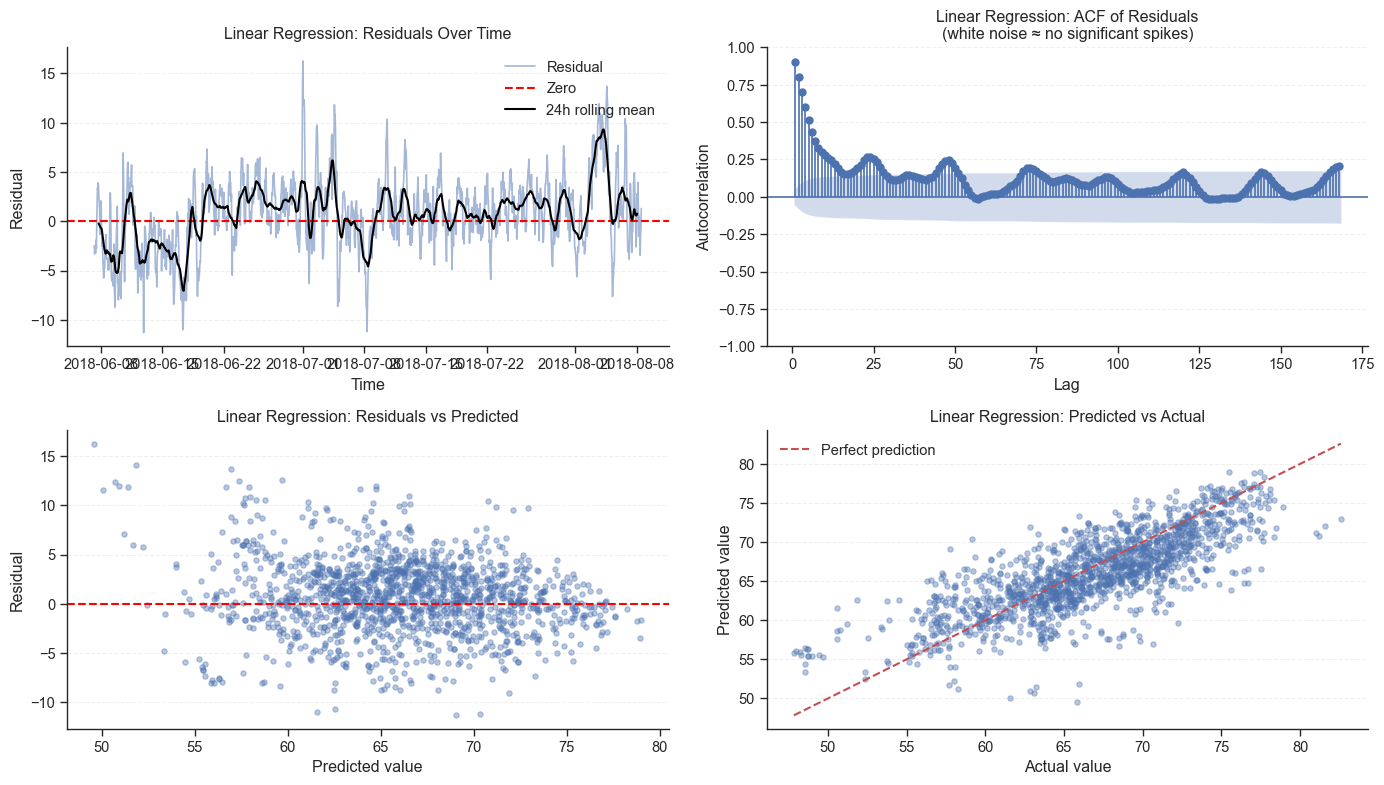

In [ ]:
# Residual analysis for linear regression
residual_analysis_ts(
    result_lin_day_ahead["y_test"],
    result_lin_day_ahead["y_pred"],
    model_name="Linear Regression"
)


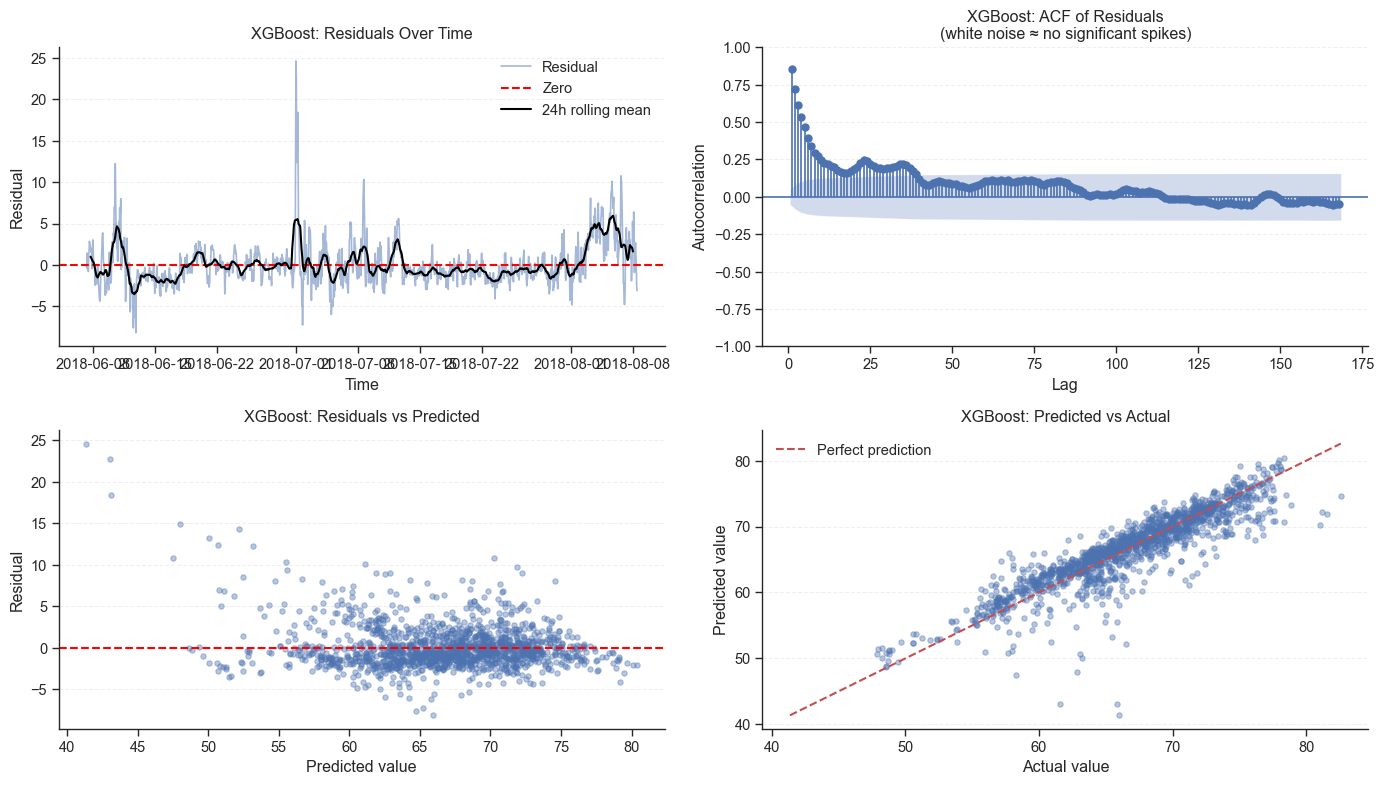

In [38]:
# Residual analysis for XGboost
residual_analysis_ts(
    result_xgb_day_ahead["y_test"],
    result_xgb_day_ahead["y_pred"],
    model_name="XGBoost"
)

#### Linear Regression
For the linear model, the residuals show visible patterns over time, and the 24-hour rolling mean often drifts away from zero. This suggests that the model does not fully capture the day-to-day dynamics of the electricity price.  
The autocorrelation plot also shows strong periodic patterns, meaning there is still time-dependent structure left in the residuals.  
When comparing predicted vs. actual values, the model gets the general trend right, but there is a noticeable spread around the diagonal line, especially at higher prices.

#### XGBoost
For XGBoost, the residuals are much more centered around zero and show fewer large spikes. The rolling mean stays close to zero, indicating a better fit.  
The autocorrelation of residuals is also weaker, meaning the model manages to capture more of the temporal trends.  
The predicted vs. actual plot shows points much closer to the ideal diagonal, illustrating that XGBoost produces more accurate predictions overall.

### Feature Importance

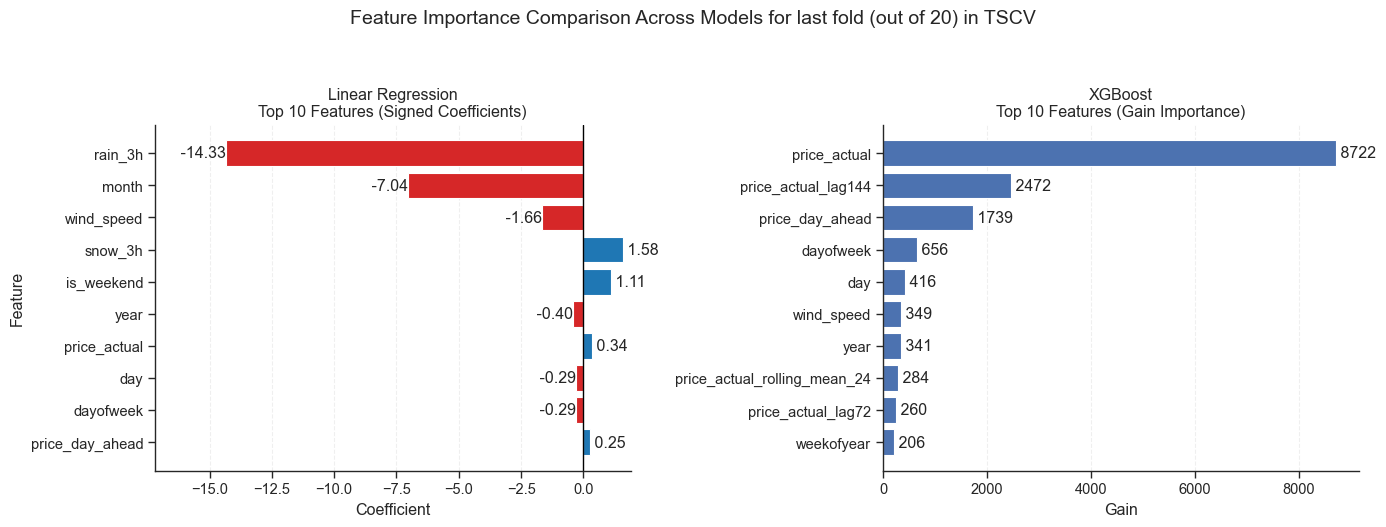

In [39]:
# Feature importance
feature_names = np.array(features)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ============================================================
# 1) Linear Regression Feature Importance
# ============================================================

lin_coefs = result_lin_day_ahead["model"].coef_.ravel()

lin_df = pd.DataFrame({
    "feature": feature_names,
    "coef": lin_coefs
})

lin_top = (
    lin_df.assign(abs_coef=lambda d: d["coef"].abs())
          .sort_values("abs_coef", ascending=False)
          .head(10)
)

# Color by sign
lin_colors = lin_top["coef"].apply(lambda c: "#1f77b4" if c > 0 else "#d62728")

ax = axes[0]
ax.barh(
    lin_top["feature"][::-1],
    lin_top["coef"][::-1],
    color=lin_colors[::-1]
)

ax.axvline(0, color="black", linewidth=1)
ax.set_title("Linear Regression\nTop 10 Features (Signed Coefficients)")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.xaxis.grid(True, linestyle="--", alpha=0.3)
sns.despine(ax=ax)

coef_min = lin_top["coef"].min()   # most negative
coef_max = lin_top["coef"].max()   # most positive

padding = 0.2
pad_left = padding * abs(coef_min)
pad_right = padding * abs(coef_max)

ax.set_xlim(coef_min - pad_left, coef_max + pad_right)

# Annotate
for i, val in enumerate(lin_top["coef"][::-1]):
    ax.text(val, i, f" {val:.2f}", va="center",
            ha="left" if val > 0 else "right")

# ============================================================
# 2) XGBoost Feature Importance
# ============================================================

xgb_items = []
raw = result_xgb_day_ahead["model"].get_booster().get_score(importance_type="gain")

for k, v in raw.items():
    if k.startswith("f") and k[1:].isdigit():
        fname = feature_names[int(k[1:])]
    else:
        fname = k
    xgb_items.append((fname, v))

xgb_df = (
    pd.DataFrame(xgb_items, columns=["feature", "importance"])
    .groupby("feature", as_index=False)["importance"].sum()
    .sort_values("importance", ascending=False)
    .head(10)
)

ax2 = axes[1]
ax2.barh(
    xgb_df["feature"][::-1],
    xgb_df["importance"][::-1],
    color="#4c72b0"
)

ax2.set_title("XGBoost\nTop 10 Features (Gain Importance)")
ax2.set_xlabel("Gain")
ax2.set_ylabel("")
ax2.xaxis.grid(True, linestyle="--", alpha=0.3)
sns.despine(ax=ax2)

# Annotate
for i, val in enumerate(xgb_df["importance"][::-1]):
    ax2.text(val, i, f" {val:.0f}", va="center", ha="left")

# ============================================================
# Overall figure title
# ============================================================

fig.suptitle(
    "Feature Importance Comparison Across Models for last fold (out of 20) in TSCV",
    y=1.05,
    fontsize=14
)

plt.tight_layout()
plt.show()


A key point to keep in mind when looking at these plots is that they do not directly show which features are “most important” for prediction in an absolute sense.  
For Linear Regression, the magnitude of a coefficient depends heavily on the scale of the underlying feature. A feature like *rain_3h* may appear extremely important simply because its raw values are small, which forces the model to use a large coefficient. Conversely, features with naturally large values can end up with small coefficients even if they matter a lot.  
For XGBoost, what we see is the **gain**, which reflects how much a feature improved the model when it was used for a split. This gives a better, but still not perfect, picture of feature importance.

#### Linear Regression
In the linear model, we see that some weather features with low numeric values, such as *rain_3h*, get disproportionately large coefficients. This is interesting but also expected given the lack of scaling. It is plausible that sudden changes in weather can have a noticeable effect on electricity prices, especially in a Mediterranean country like Spain, where heavy rain is less common and may disrupt typical production patterns.  
Aside from these weather-related features, we also see high importance for strongly correlated price features like *price_actual* and *price_day_ahead*. Temporal variables such as *day*, *year*, and *dayofweek* also appear, suggesting that the model has captured some of the regular seasonal or structural patterns in electricity prices.

#### XGBoost
For XGBoost, the results align more closely with what we would expect for a time-series problem. The model prioritizes **lag features**, which are known to be highly correlated with future prices. These features dominate the feature importance ranking, showing that the model heavily relies on recent price movements.  
We also see that temporal features such as *year* and *dayofweek* play a role, indicating that the model finds recurring seasonal structure in the data. The presence of *wind_speed* among the top features is notable, it suggests that wind conditions may significantly influence electricity prices, likely through their effect on renewable energy production.

Overall, both models highlight reasonable aspects of the system, but XGBoost provides a more reliable picture of what truly drives predictive performance.

## Final model
### Final model
Since the XGBRegressor performed best we decide to use this for our final model.

In [ ]:
# Train final model 
final_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

final_model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Saving the model
We save the model into a folder as a joblib so we dont have to train it again every time we want to use it. We also save some metadata.

In [ ]:
# save the model

# Finding importances
xgb_items = []
raw = final_model.get_booster().get_score(importance_type="gain")

for k, v in raw.items():
    if k.startswith("f") and k[1:].isdigit():
        fname = feature_names[int(k[1:])]
    else:
        fname = k
    xgb_items.append((fname, v))

final_importance_df = (
    pd.DataFrame(xgb_items, columns=["feature", "importance"])
    .groupby("feature", as_index=False)["importance"].sum()
    .sort_values("importance", ascending=False)
)

# Saving the model:
Path("best_model").mkdir(exist_ok=True)

# Save model
joblib.dump(final_model, "best_model/model.joblib")

# Save metadata (feature names, target, imputation method)
meta = {
    "feature_names": list(X_train.columns),
    "target": target,
    "feature_importance": final_importance_df.to_dict(orient="records"),
}
with open("best_model/model_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=4)

print(" Model and metadata saved in best_model/")

 Model and metadata saved in best_model/


For use in our generative model we save the last 24 entries of the test set. This way we can try to use our modell through the rest api with realistic data.

In [ ]:
# Helper functions to save input data 
def get_project_root() -> Path:
    """Return project root whether running from script or notebook."""
    if hasattr(sys.modules['__main__'], '__file__'):
        # Running from a .py script (FastAPI)
        return Path(sys.modules['__main__'].__file__).resolve().parent.parent
    else:
        # Running from Jupyter Notebook
        return Path.cwd().parent
    

def get_predictions_file_path(country_code: str) -> Path:
    """Get the file path for the predictions CSV (Notebook + FastAPI safe)."""
    project_root = get_project_root()
    return project_root / f"data/{country_code}/predictions/{country_code}_predictions.csv"

def save_prediction_to_csv(df: pd.DataFrame, country_code: str = "ES"):
    """Save prediction rows to CSV with auto-incrementing IDs."""
    file_path = get_predictions_file_path(country_code)
    file_path.parent.mkdir(parents=True, exist_ok=True)

    # If file exists: load it and append new rows
    if file_path.exists():
        existing_df = pd.read_csv(file_path)

        # Determine next ID
        next_id = existing_df["id"].max() + 1

        # Assign incremental IDs to the incoming df
        df = df.copy()
        df.insert(0, "id", range(next_id, next_id + len(df)))

        # Concatenate
        final_df = pd.concat([existing_df, df], ignore_index=True)

    else:
        # First time storing → start IDs at 1
        df = df.copy()
        df.insert(0, "id", range(1, 1 + len(df)))
        final_df = df

    # Save file
    final_df.to_csv(file_path, index=False)
    print(f"Saved {len(df)} predictions up to ID {final_df['id'].max()} to {file_path}")


In [ ]:
# Saving the last 24 elements of X_test
last = X_test.iloc[-24:]
save_prediction_to_csv(last, country_code="ES")

Saved 24 predictions up to ID 48 to c:\Users\Bruker\Documents\School\Bachelor Matematisk modellering\3. semester\DATA3800\DATA3800-WattTommorrow\data\ES\predictions\ES_predictions.csv


### Potential improvements
In order to further improve predicitons one could:
- Try different modells that are made specifically for timeseries data like ARIMA
- Add cyclical featuers like sin and cos.